In [1]:
library("geosphere")

In [2]:
nodes <- read.csv("ITA_nodes.csv")
edges <- read.csv("ITA_edges.csv")

distancies <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in 1:nrow(nodes)) {
  for (j in 1:nrow(nodes)) {
    distancies[i, j] <- distHaversine(c(nodes$lon[i], nodes$lat[i]), c(nodes$lon[j], nodes$lat[j]))
  }
}

In [3]:
flows <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in 1:nrow(nodes)) {
  for (j in 1:nrow(nodes)) {
    # Subset edges data frame to get estimated flow from node i to node j
    matched_edges <- edges$estimated_flow[edges$from == i & edges$to == j]
    
    # Check if there are any matches
    if (length(matched_edges) > 0) {
      # If matches found, assign the first value to flows[i, j]
      flows[i, j] <- matched_edges[1]
    } else {
      flows[i, j] <- 0
    }
  }
}

In [4]:
GravityModel <- function(i, j, alpha, beta, k, d0){
  num <- nodes$population[i]^alpha * nodes$population[j]^beta
  den <- exp(distancies[i, j]/d0)

  return (k * num / den)
}

GravityModel(1, 5, 0.5, 1, 0.005, 10000)

[1] 2219.575

In [5]:
# Define loss function
loss_function <- function(params) {
  loss <- 0
  
  for (i in 1:nrow(nodes)) {
    for (j in 1:ncol(nodes)) {
      predicted_flow <- GravityModel(i, j, alpha = params[1], beta = params[2], k = params[3], d0 = params[4])
      loss <- loss + (flows[i, j] - predicted_flow)^2
    }
  }
  
  return(loss)
}

# Initial guess for parameters
initial_params <- c(1, 1, 0.005, 10000)

# Minimize the loss function using optim
optimal_params <- optim(initial_params, loss_function)$par

In [6]:
optimal_params

[1]   -61.500    32.250    31.255 10031.250

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


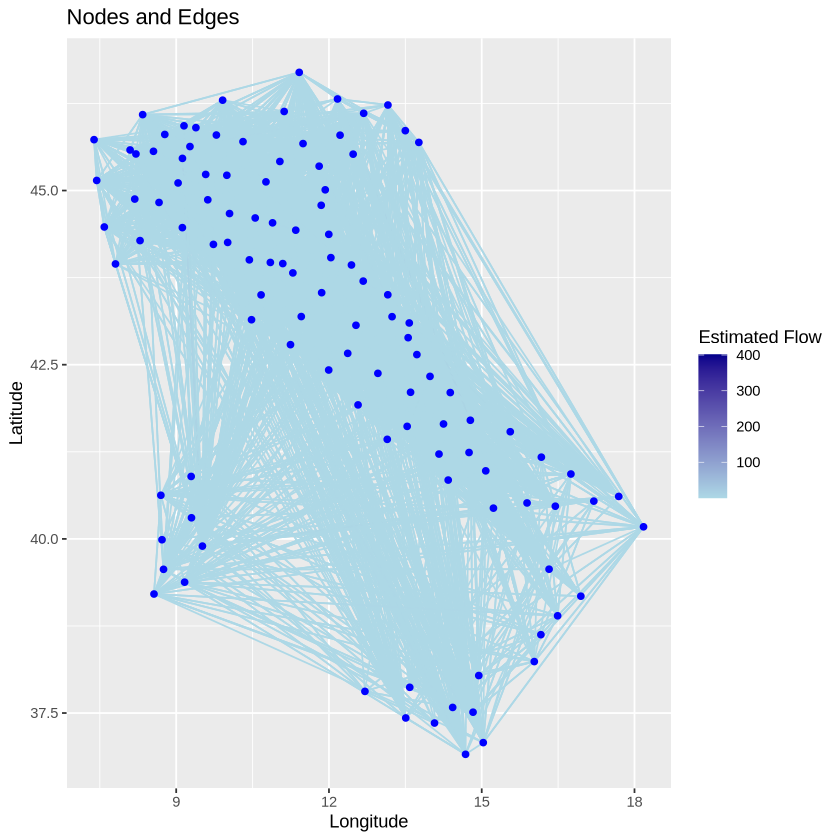

In [7]:
library(ggplot2)

# Filter out negative or NA estimated_flow values
edges_filtered <- edges[edges$estimated_flow > 0, ]

# Combine plots
combined_plot <- ggplot() +
  geom_segment(data = edges_filtered, aes(x = nodes$lon[from], y = nodes$lat[from],
                                          xend = nodes$lon[to], yend = nodes$lat[to], color = estimated_flow/10000), 
               size = 0.5) + 
  geom_point(data = nodes, aes(x = lon, y = lat), color = "blue", size = 1.5) +  # Plot nodes
  labs(x = "Longitude", y = "Latitude", title = "Nodes and Edges") +  # Set axis labels and title
  scale_color_gradient(name = "Estimated Flow", low = "lightblue", high = "darkblue")  # Define color scale

# Display combined plot
print(combined_plot)

In [8]:
RadiationModel <- function(i, j, alpha, beta, k, d0){
  num <- nodes$population[i]^alpha * nodes$population[j]^beta
  den <- exp(distancies[i, j]/d0)

  return (k * num / den)
}

RadiationModel(1, 5, 0.5, 1, 0.005, 10000)

[1] 2219.575

In [9]:
# Define loss function
loss_function <- function(params) {
  loss <- 0
  
  for (i in 1:nrow(nodes)) {
    for (j in 1:ncol(nodes)) {
      predicted_flow <- RadiationModel(i, j, alpha = params[1], beta = params[2], k = params[3], d0 = params[4])
      loss <- loss + (flows[i, j] - predicted_flow)^2
    }
  }
  
  return(loss)
}

# Initial guess for parameters
initial_params <- c(1, 1, 0.005, 10000)

# Minimize the loss function using optim
optimal_params <- optim(initial_params, loss_function)$par